In [11]:
import numpy as np
import os
import matplotlib.pylab as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns
sns.set_context("paper")

In [12]:
nb_dir     = os.getcwd()
rdir       = os.path.join(nb_dir, "./Results/")
params = {'figure.figsize': (10,6), 'savefig.bbox': 'tight', 'axes.grid' : False, 'errorbar.capsize' : 3, 
          'axes.titlesize': 16, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14}
plt.rcParams.update(params)
# %config InlineBackend.figure_format='retina'
def save_plt(n): 
    plt.savefig(os.path.join(rdir,"%s.pdf" % (n))); 
    plt.savefig(os.path.join(rdir,"%s.png" % (n)),dpi=300)

In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

Text(0.5, 0, '$\\mathregular{\\lambda} (nm)$')

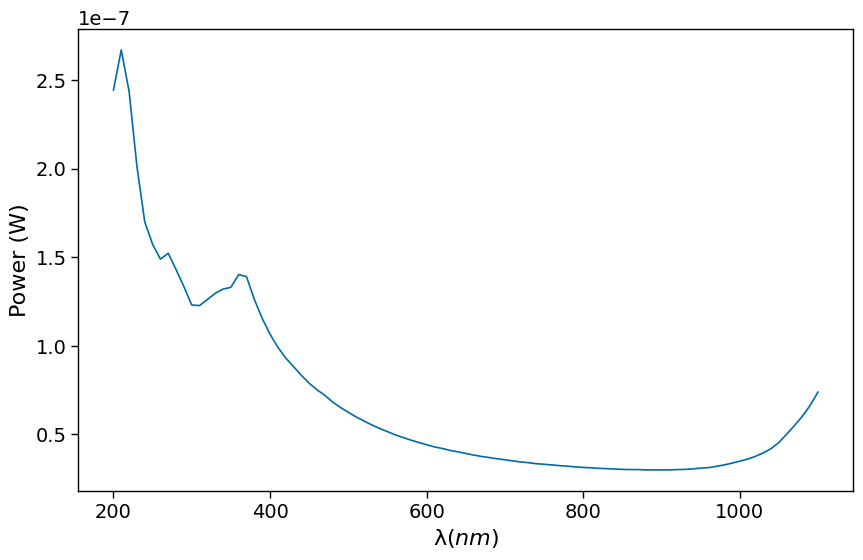

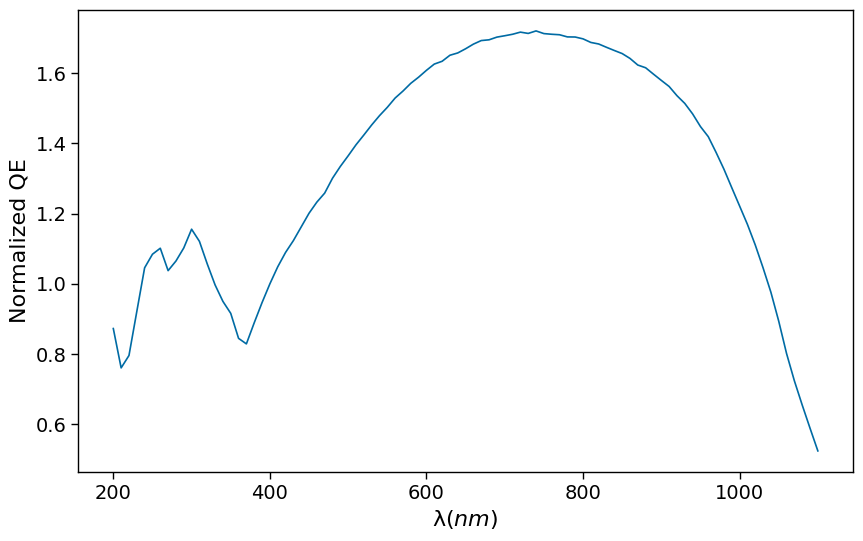

In [14]:
# No Attenuator
out_file = './Meas/01/d20230427_154620_wavelength_scan.txt' # No att
out_file = './Data/d20230427_154620_wavelength_scan_no_attenuator.txt' #Isa

time_meas, wave, mean_power, std_power = np.loadtxt(out_file, unpack=True)

# Evaluation of error
peak_w, i_peak = find_nearest(wave, 400)
peak_power = mean_power[i_peak]
qe_r = peak_power / mean_power * 400 / wave



fig,ax = plt.subplots()
ax.plot(wave, mean_power)
ax.set_ylabel("Power (W)")
ax.set_xlabel("$\mathregular{\lambda} (nm)$")
fig,ax = plt.subplots()
ax.plot(wave, qe_r)
# ax.set_yscale('log')
ax.set_ylabel("Normalized QE")
ax.set_xlabel("$\mathregular{\lambda} (nm)$")

In [15]:
def line(B, x):
    m,q = B
    return m*x + q

In [16]:


print(f"Nearest value to peak: {peak_w} nm\nPeak power = {peak_power}")

closest_powers = [ mean_power[i_peak -2],mean_power[i_peak - 1], mean_power[i_peak +1], mean_power[i_peak +2]]
closest_waves = [wave[i_peak - 2],wave[i_peak - 1], wave[i_peak + 1],wave[i_peak +2]]
closest_qer = [qe_r[i_peak -2],qe_r[i_peak - 1], qe_r[i_peak + 1],qe_r[i_peak +2]]
print(f"Closest power values = {closest_powers} W")
print(f"Closest wavelengths = {closest_waves} nm")
print(f"Closest relative quantum efficiencies = {closest_qer}")
diff_qe_r = abs(np.asarray(closest_qer) - qe_r[i_peak])
print(f"Differences w.r.t. peak qe_r = {diff_qe_r}")
sigma_rel = np.mean(diff_qe_r/qe_r[i_peak])
print(f"Relative sigma on power values between {wave[i_peak - 1]} and {wave[i_peak + 1]} nm = {sigma_rel}")




Nearest value to peak: 400.0 nm
Peak power = 1.066e-07
Closest power values = [1.262e-07, 1.155e-07, 9.92e-08, 9.32e-08] W
Closest wavelengths = [380.0, 390.0, 410.0, 420.0] nm
Closest relative quantum efficiencies = [0.8891483860205188, 0.9466089466089466, 1.0483870967741937, 1.0893112609850806]
Differences w.r.t. peak qe_r = [0.11085161 0.05339105 0.0483871  0.08931126]
Relative sigma on power values between 390.0 and 410.0 nm = 0.07548525628245223


Relative QE at 397 nm = [0.9822313]
Relative QE at 405 nm = [1.02294256]
Relative QE at 413 nm = [1.06066435]
qe_r_405 - qe_r_397 = [0.04071126]
qe_r_405 - qe_r_413 = [0.03772179]
qe_r_405 - qe_r_400 = [0.02544454]
Sigma on measures = 0.03921652343533838
parameters = [ 0.00503363 -1.01817292]


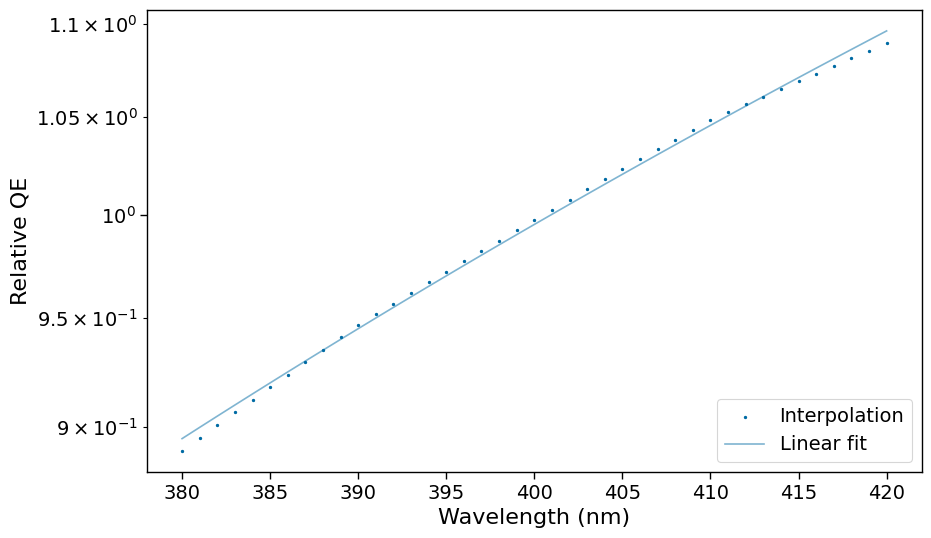

In [17]:
from scipy.odr import ODR, Model, Data

pos_int = np.arange(np.amin(closest_waves), np.amax(closest_waves) + 1, 1, dtype=int)
qe_r_interp = np.interp(pos_int, closest_waves, closest_qer)

qe_r_405nm = qe_r_interp[pos_int == 405]
qe_r_397nm = qe_r_interp[pos_int == 397]
qe_r_413nm = qe_r_interp[pos_int == 413]
print(f"Relative QE at 397 nm = {qe_r_397nm}")
print(f"Relative QE at 405 nm = {qe_r_405nm}")
print(f"Relative QE at 413 nm = {qe_r_413nm}")
sigma_1 = abs(qe_r_405nm-qe_r_397nm)
sigma_2 = abs(qe_r_405nm-qe_r_413nm)
print(f"qe_r_405 - qe_r_397 = {sigma_1}\nqe_r_405 - qe_r_413 = {sigma_2}\nqe_r_405 - qe_r_400 = {abs(qe_r_405nm- qe_r_interp[pos_int == 400])}")
sigma_on_measures = np.mean([sigma_2, sigma_1])
print(f"Sigma on measures = {sigma_on_measures}")
mod = Model(line)
mydata = Data(pos_int, qe_r_interp)
myodr = ODR(mydata, mod, beta0=[1.,0.])
out = myodr.run()

print(f"parameters = {out.beta}")

fig, ax = plt.subplots()
plt.scatter(pos_int, qe_r_interp, label = 'Interpolation', marker = ".", s = 10)
plt.plot(pos_int, line(out.beta, pos_int), label = 'Linear fit', alpha = 0.5)
plt.xlabel("Wavelength (nm)")
ax.set_yscale("log")
plt.ylabel("Relative QE")
plt.title("", size = 9)
plt.legend(loc = "lower right")

Text(0.5, 0, '$\\mathregular{\\lambda} (nm)$')

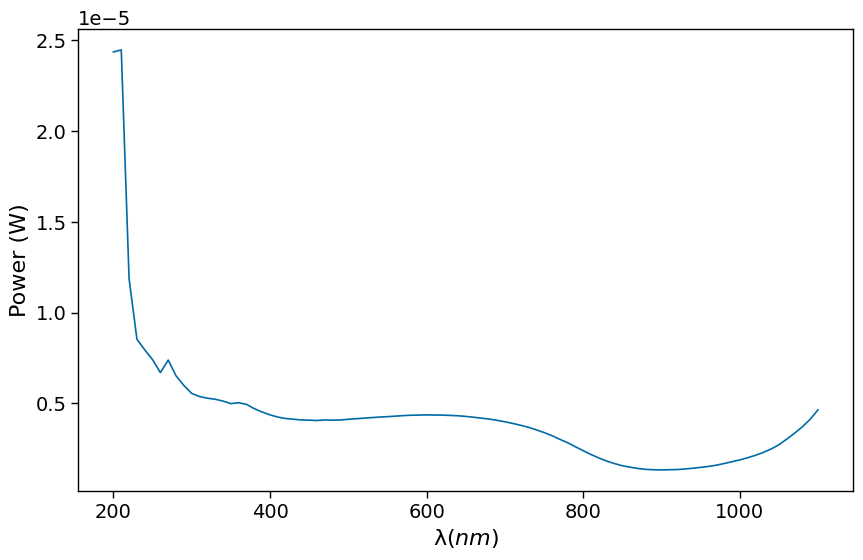

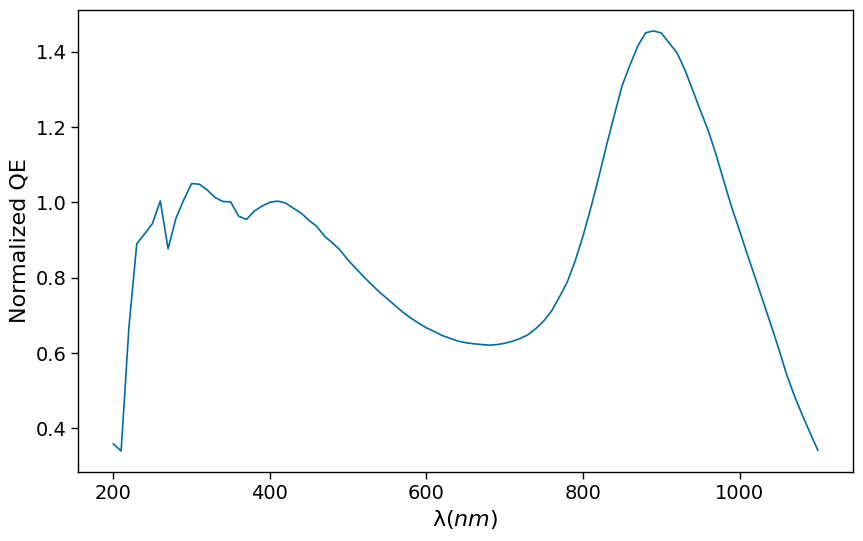

In [18]:
# With OD3
#out_file = './Meas/01/d20230427_172246_wavelength_scan.txt'
out_file = './Data/d20230427_172246_wavelength_scan.txt' #Isa

time_meas, wave, mean_power, std_power = np.loadtxt(out_file, unpack=True)
qe_r_att = mean_power[wave==400] / mean_power * 400 / wave

fig,ax = plt.subplots()
ax.plot(wave, mean_power)
ax.set_ylabel("Power (W)")
ax.set_xlabel("$\mathregular{\lambda} (nm)$")
fig,ax = plt.subplots()
ax.plot(wave, qe_r_att)
# ax.set_yscale('log')
ax.set_ylabel("Normalized QE")
ax.set_xlabel("$\mathregular{\lambda} (nm)$")

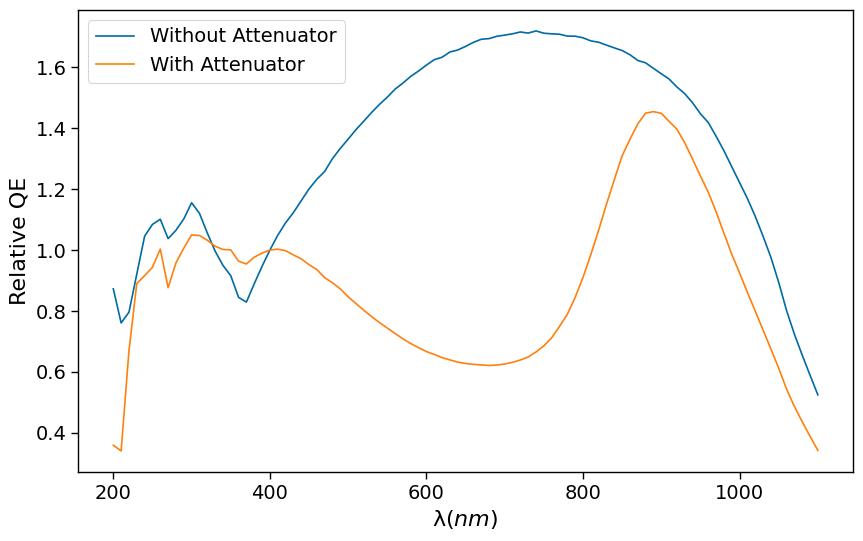

In [21]:
fig,ax = plt.subplots()
ax.set_xlabel("$\mathregular{\lambda} (nm)$")
ax.set_ylabel("Relative QE")
ax.plot(wave, qe_r, label='Without Attenuator')
ax.plot(wave, qe_r_att, label='With Attenuator')
plt.legend()
fig.savefig("./Plots/QE_rel_with_without_att.svg")


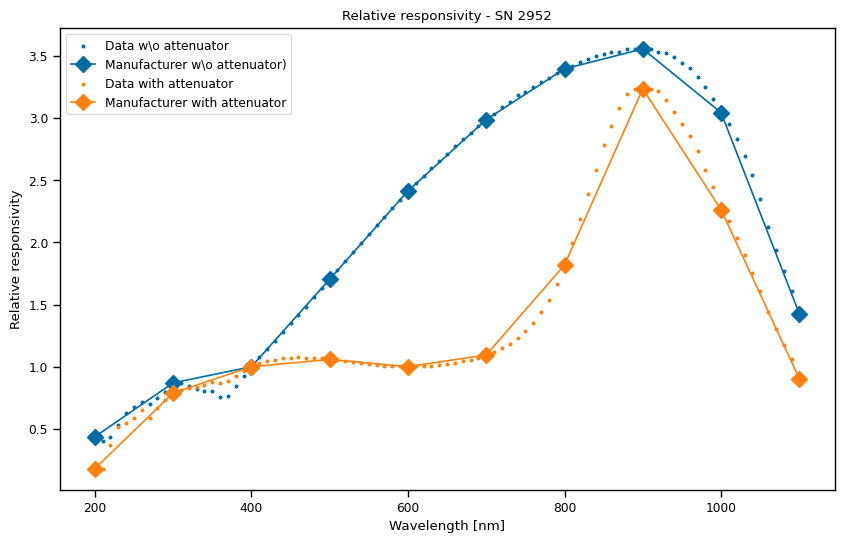

In [22]:
sns.set_context("paper")
lamb, resp_noatt, resp_att = np.loadtxt("./Data/responsivity_2952.txt", unpack = True)
#fig, ax = plt.subplots()
#ax.plot(lamb, resp, label = "Specs")
rel_resp = resp_noatt/resp_noatt[lamb == 400]
rel_resp_data = qe_r/qe_r[wave == 400] * wave/400
rel_resp_data_att = qe_r_att/qe_r_att[wave == 400] * wave/400
rel_resp_att = resp_att/resp_att[lamb == 400]

fig, ax = plt.subplots()
ax.scatter(wave, rel_resp_data, s = 17, marker = ".", label = "Data w\o attenuator")
ax.plot(lamb, rel_resp, marker = 'D', markersize = 8, label = "Manufacturer w\o attenuator)")
ax.scatter(wave, rel_resp_data_att, s = 17, marker = ".", label = "Data with attenuator")
ax.plot(lamb, rel_resp_att, marker = 'D', markersize = 8,label = "Manufacturer with attenuator")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Relative responsivity")
ax.legend()
ax.set_title("Relative responsivity - SN 2952")
fig.savefig("./Plots/relative_responsivity_2952.svg")